<a id="topotopo"></a>

# Top

Auxiliary functions

<a href="#distr_groups"> 1. Distribuições de cada conjunto de grouped stratified sampling, por classe.</a>

<a href="#hpsklearn"> 2. HPO com __hpsklearn__.</a>

<a href="#hyperopt"> 3. HPO com __hyperopt__.</a>

<a href="#melhoraccuracy"> 4. Melhor RF em overall accuracy, com grouped stratified sampling</a>

<a href="#melhorf1"> 5. Melhor RF em F1-score cashew, com grouped stratified sampling</a>

<a href="#geemap"> 6. Passagem de modelo para GEE.</a>

___

* Simples import dos dados e separação em treino e teste

In [1]:
import shapely
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tabulate import tabulate
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, StratifiedGroupKFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score

palette = ['#006600', '#99ff33', '#2d8659', '#c6538c', '#808000', '#804000', '#0000ff']
class_names = ['Closed Forest', 'Open Forest', 'Mangrove', 'Savanna', 'Cashew', 'Non-Forest', 'Water']

custom_scorer = metrics.make_scorer(lambda y_true, y_pred: metrics.recall_score(y_true, y_pred, labels=[5], average='micro')) #5 corresponds to cashew

random_state=0

In [2]:
s2cc_concat = pd.read_csv("/home/mrp2106/Projeto/ML - visual polygons/Data/s2cc_concat.csv")
treino = pd.read_csv("/home/mrp2106/Projeto/ML - visual polygons/Data/s2cc_treino.csv")
teste = pd.read_csv("/home/mrp2106/Projeto/ML - visual polygons/Data/s2cc_teste.csv")

# Já não têm colunas "system:index" e ".geo"

In [3]:
coords = s2cc_concat[["longitude","latitude"]]
groups = s2cc_concat["groupID"]

X = s2cc_concat.drop(columns=["system:index",".geo","C_ID_1","longitude","latitude","groupID"])
y = s2cc_concat["C_ID_1"]

<a id="distr_groups"></a>
___

# Grouped stratified sampling class distributions

<a href="#topotopo"> Back to top.</a>

In [4]:
def sgkfShow(sgkf, X, y, groups):
    percentages_train = []
    percentages_val = []
    
    for i, (train_index, test_index) in enumerate(sgkf.split(X, y, groups)):
        xx_train = X.iloc[train_index,:]
        xx_val = X.iloc[test_index,:]
        
        yy_train = y[train_index]
        yy_val = y[test_index]
    
        unique_labels, label_counts = np.unique(y, return_counts=True)
        
        clusters_train = groups[train_index]
        clusters_test = groups[test_index]
    
        print("Iteration " + str(i) + ":")
        
        unique_labels_train, label_counts_train = np.unique(yy_train, return_counts=True)
        unique_labels_test, label_counts_test = np.unique(yy_val, return_counts=True)
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1,2,1)
    
        per_train = []
        per_val = []
        for j, label in enumerate(unique_labels_train):
            plt.bar(label, label_counts_train[j], color=palette[j]) #Contagens
            #plt.bar(label, label_counts_train[j]/len(yy_train), color=palette[j]) #Normalized
            per_train.append(label_counts_train[j]/len(yy_train))
        
        plt.xticks(ticks=np.arange(1,8),labels=class_names,rotation=45)
        plt.xlabel('Class Label')
        plt.ylabel('Number of Points')
        plt.title("Train barplot")
    
        plt.subplot(1,2,2)
    
        
        for j, label in enumerate(unique_labels_test):
            plt.bar(label, label_counts_test[j], color=palette[j]) #Contagens
            #plt.bar(label, label_counts_test[j]/len(yy_val), color=palette[j]) #Normalized
            per_val.append(label_counts_test[j]/len(yy_val))
        
        plt.xticks(ticks=np.arange(1,8),labels=class_names,rotation=45)
        plt.xlabel('Class Label')
        plt.ylabel('Number of Points')
        plt.title("Test barplot")
        plt.show()
    
        percentages_train.append(per_train)
        percentages_val.append(per_val)

    percentages_train = np.array(percentages_train)
    percentages_val = np.array(percentages_val)
    
    print("Train \n")
    print(tabulate(np.round(percentages_train,3), headers=class_names))
    print("\n Test \n")
    print(tabulate(np.round(percentages_val,3), headers=class_names))

Iteration 0:


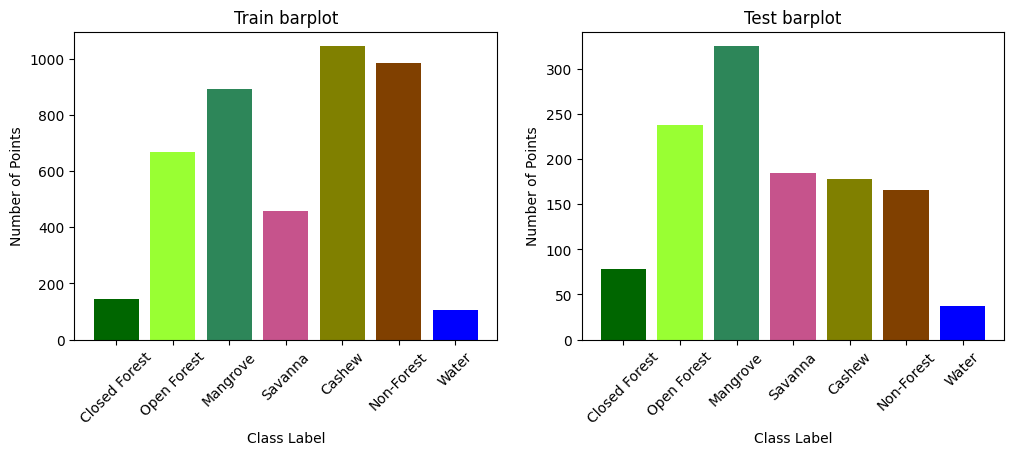

Iteration 1:


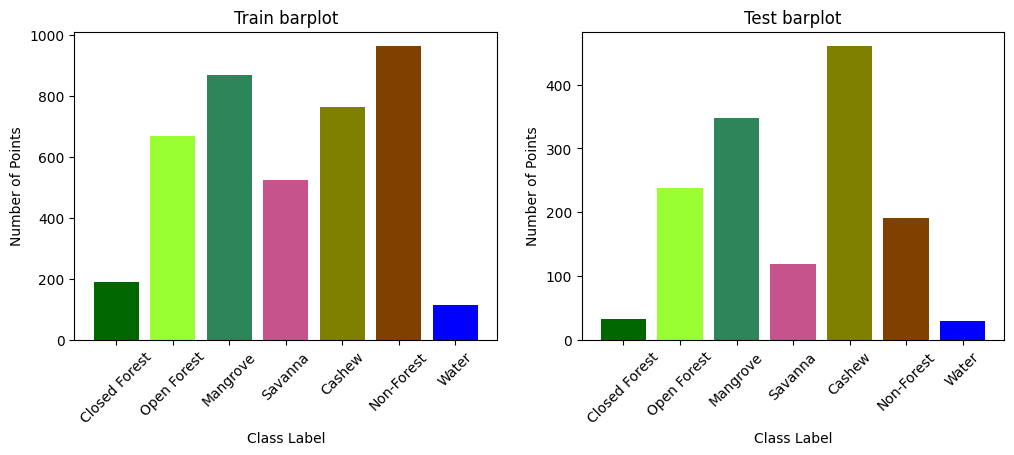

Iteration 2:


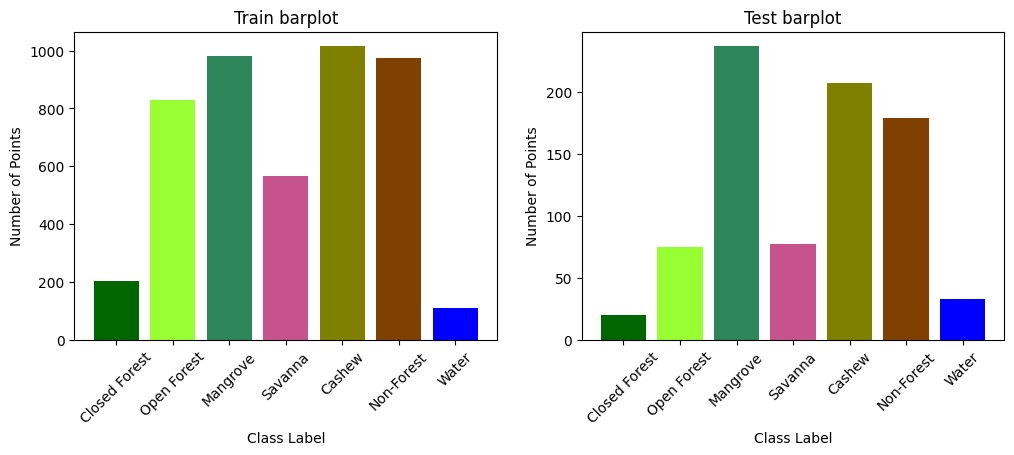

Iteration 3:


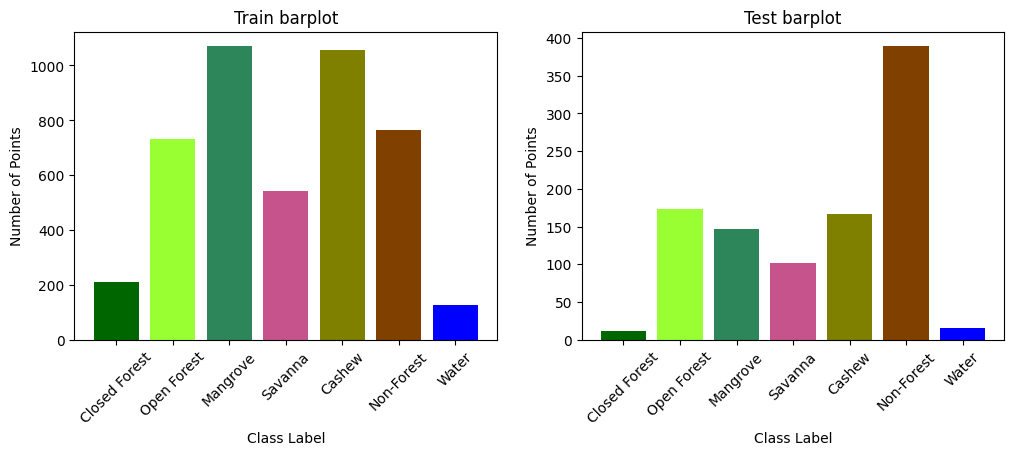

Iteration 4:


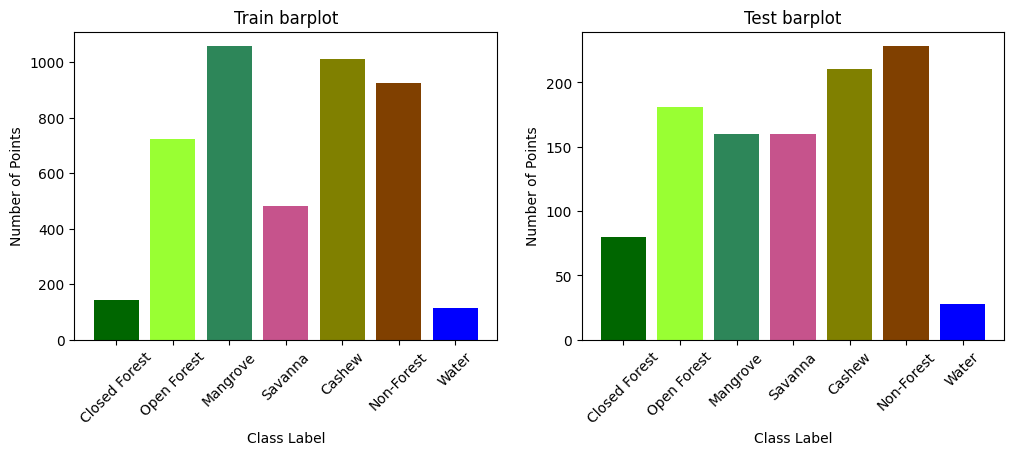

Train 

  Closed Forest    Open Forest    Mangrove    Savanna    Cashew    Non-Forest    Water
---------------  -------------  ----------  ---------  --------  ------------  -------
          0.034          0.155       0.208      0.106     0.243         0.23     0.024
          0.047          0.163       0.213      0.128     0.186         0.235    0.028
          0.043          0.178       0.21       0.121     0.217         0.208    0.023
          0.047          0.163       0.238      0.12      0.235         0.17     0.028
          0.032          0.163       0.237      0.108     0.227         0.207    0.026

 Test 

  Closed Forest    Open Forest    Mangrove    Savanna    Cashew    Non-Forest    Water
---------------  -------------  ----------  ---------  --------  ------------  -------
          0.065          0.197       0.269      0.153     0.147         0.138    0.031
          0.023          0.168       0.246      0.084     0.325         0.134    0.02
          0.024          0.

In [5]:
sgkf = StratifiedGroupKFold(n_splits=5,shuffle=True,random_state=0)

sgkfShow(sgkf, X, y, groups)

_____

## Hyperparameter tuning (hyperopt library)

__Nota:__ hyperopt 0.2.7 dá erro _AttributeError: 'numpy.random.mtrand.RandomState' object has no attribute 'integers'_.

Vem de alteração na versão 0.2.5 que usa uma cena antiga de numpy que já não existe. Solução é dar downgrade de hpsklearn para 0.2.5

__Mas:__ com hyperopt 0.2.5 aparece outro erro _AttributeError: module 'numpy' has no attribute 'int'._

* Line 279 _hyperopt fmin.py_ - self.rstate.integers -> self.rstate.randint
* Line 259 _hpsklearn estimator.py_ - tinha dtype=np.int, passei para int

https://github.com/hyperopt/hyperopt/issues/829

__Outro:__ usando só hyperopt aparece também erro _'numpy.random._generator.Generator' object has no attribute 'randint'_ - acrescentar _rstate=np.random.RandomState(42)_


* __Define Search spaces:__ http://hyperopt.github.io/hyperopt/getting-started/search_spaces/

<a id="hpsklearn"></a>

* __Forma usando hpsklearn:__ _HyperoptEstimator

<a href="#topotopo"> Back to top.</a>

In [20]:
from hpsklearn import HyperoptEstimator, any_sparse_classifier, tfidf, random_forest
from sklearn import metrics
from hyperopt import tpe, rand, hp

n_estimators = np.arange(50,550,50,dtype=int)
max_feat = np.linspace(3,126,7,dtype=int)
max_dep = np.linspace(1,9,5,dtype=int)

hip_grid = {"n_estimators": n_estimators,
            "max_features": max_feat,
            "max_depth": max_dep}

#hp_criterion = hp.pchoice("criterion", [(0.5,"gini"), (0.5,"entropy")])
hp_nestim = hp.uniformint("n_estimators", low=50, high=550, q=10)
hp_maxdepth = hp.uniformint("max_depth", low=1, high=12, q=3)
hp_maxfeat = hp.uniformint("max_features", low=3, high=126, q=7)

if __name__ == "__main__":
    # Instantiate a HyperoptEstimator with the search space and number of evaluations
    estim = HyperoptEstimator(classifier=random_forest("my_rf", n_estimators = hp_nestim, max_depth = hp_maxdepth, max_features=hp_maxfeat),
                              preprocessing=[],
                              algo=tpe.suggest,
                              max_evals=100,
                              trial_timeout=7500)

    estim.fit(np.array(X_train), np.array(y_train)) #eq a X_train.values, library não lida com pd.DataFrames

    print("Test accuracy: ", estim.score(X_test, y_test))
    print(estim.best_model())

100%|██████| 100/100 [00:00<00:00,  1.16trial/s, best loss: 0.38377192982456143]
Test accuracy:  0.9151643690349947
{'learner': RandomForestClassifier(bootstrap=False, max_depth=9, max_features=9,
                       n_estimators=292, n_jobs=1, random_state=0,
                       verbose=False), 'preprocs': (), 'ex_preprocs': ()}


In [24]:
rf = RandomForestClassifier(n_estimators=10,max_depth=4)
cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

array([0.68092105, 0.70942982, 0.8377193 , 0.8497807 , 0.79034029])

<a id="hyperopt"></a>

* __Forma usando hyperopt:__ _fmin()_

<a href="#topotopo"> Back to top</a>

* __Maximizar overall accuracy:__

In [25]:
from hyperopt import hp, tpe, fmin
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def f1_cashew(y_target,y_prediction):
    print(f1_score(y_target, y_prediction, average=None))
    return 1-f1_score(y_target, y_prediction, labels=[5], average=None)

# Define the objective function
def objective(params):
    clf = RandomForestClassifier(**params)
    return -np.mean(cross_val_score(clf, X_train.values, y_train.values, cv=5, n_jobs=-1, scoring='accuracy'))

# Define the search space
space = {
    'n_estimators': hp.uniformint("n_estimators", low=50, high=550, q=10),
    'max_depth': hp.uniformint("max_depth", low=1, high=12, q=3), 
    'max_features': hp.uniformint("max_features", low=3, high=126, q=7)

}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            rstate=np.random.RandomState(42),
            max_evals=100,
            timeout=7200
           )

# Print the best hyperparameters
print("Best hyperparameters:")
print(best)


100%|██████| 100/100 [27:24<00:00, 16.45s/trial, best loss: -0.8273675063069309]
Best hyperparameters:
{'max_depth': 11.0, 'max_features': 9.0, 'n_estimators': 486.0}


* __Maximizar f1-score cashew:__

In [22]:
from hyperopt import hp, tpe, fmin
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def f1_cashew(y_target,y_prediction):
    print(f1_score(y_target, y_prediction, average=None))
    return 1-f1_score(y_target, y_prediction, labels=[5], average=None)

# Define the objective function
def objective(params):
    clf = RandomForestClassifier(**params)
    return -np.mean(cross_val_score(clf, X_train.values, y_train.values == 5, cv=5, n_jobs=-1, scoring='f1'))

# Define the search space
space = {
    'n_estimators': hp.uniformint("n_estimators", low=50, high=550, q=10),
    'max_depth': hp.uniformint("max_depth", low=1, high=12, q=3), 
    'max_features': hp.uniformint("max_features", low=3, high=126, q=7)

}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            rstate=np.random.RandomState(42),
            max_evals=100,
            timeout=7200
           )

# Print the best hyperparameters
print("Best hyperparameters:")
print(best)


100%|██████| 100/100 [25:03<00:00, 15.03s/trial, best loss: -0.7837050365090289]
Best hyperparameters:
{'max_depth': 8.0, 'max_features': 19.0, 'n_estimators': 98.0}


____

## Experiências de grouped stratified Holdout partindo de StratifiedGroupedKFold do sklearn

* __Funções auxiliares:__ permitem descobrir, para um objeto StratifiedGroupKFold, qual é a iteração que dá a melhor fold para test set (aquela com class distributions mais perto das globais).

In [54]:
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

def calculate_class_proportions(labels):
    unique, counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)
    proportions = counts / total_samples
    return proportions

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Generate your StratifiedGroupKFold folds
sgkf = StratifiedGroupKFold(n_splits=5)

def sgkf_to_holdout(sgkf,X,y,groups):
    '''
    Takes in a strat grouped K-CV object, and from those K options, finds the best train-test split.
    The one whose class proportions mostly resembles the global class proportions.
    Returns: the integer of the sgkf.split() iteration that matches this best split
    '''
    
    class_proportions = []
    
    for train_index, test_index in sgkf.split(X, y, groups):
        train_labels = y[train_index]
        test_labels = y[test_index]
        class_proportion = calculate_class_proportions(test_labels)
        class_proportions.append(class_proportion)
    
    global_class_proportions = calculate_class_proportions(y)
    
    min_kl_divergence = float('inf')
    selected_fold = None
    
    for i, proportions in enumerate(class_proportions):
        kl_distance = kl_divergence(global_class_proportions, proportions)
        if kl_distance < min_kl_divergence:
            min_kl_divergence = kl_distance
            selected_fold = i
    
    return selected_fold
    

def multipleHoldouts(X,y,groups,n_iter=10):
    '''
    calls sgkf_to_holdout multiple times, using different sgkf states, to find different hypothesis of grouped stratified holdout.
    Returns: list of integers that describe the best iteration of sgkf.split for each sgkf
    '''
    best_iterations = []
    for i in range(n_iter):
        sgkf = StratifiedGroupKFold(n_splits=5,shuffle=True,random_state=i)
        best_iterations.append(sgkf_to_holdout(sgkf,X,y,groups))
    return best_iterations

print(sgkf_to_holdout(sgkf,X,y,groups))

print(multipleHoldouts(X,y,groups))

3
[4, 1, 0, 4, 3, 2, 3, 1, 3, 3]


* __Só para dar plot dos resultados de grouped stratified holdout.__ Também permite ver se há alguma iteração repetida, com o mesmo split treino e teste.

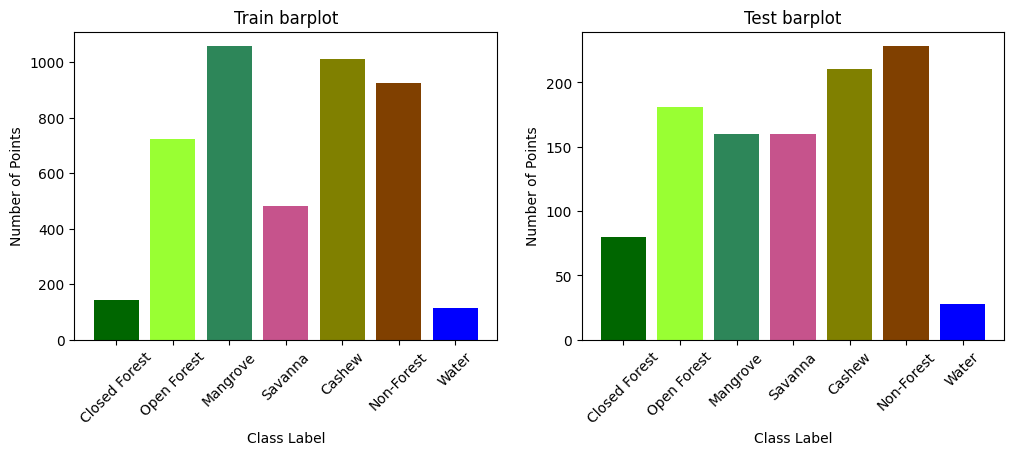

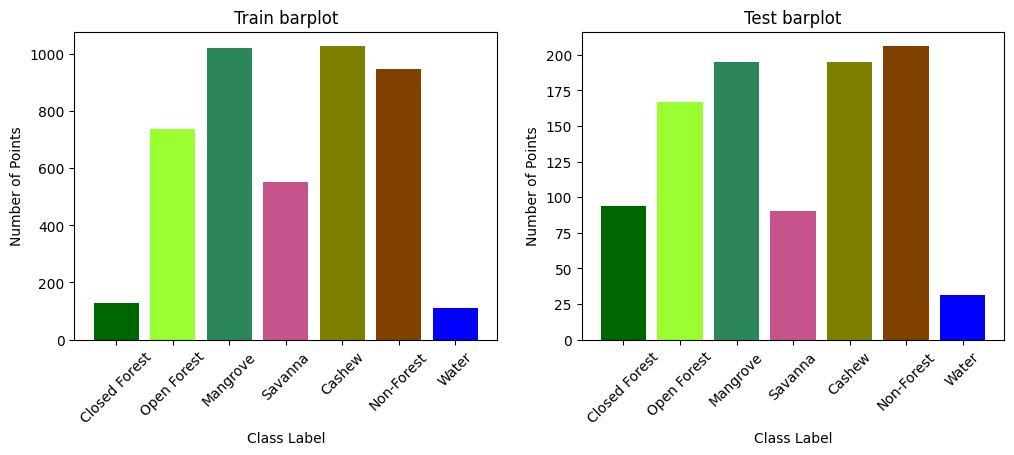

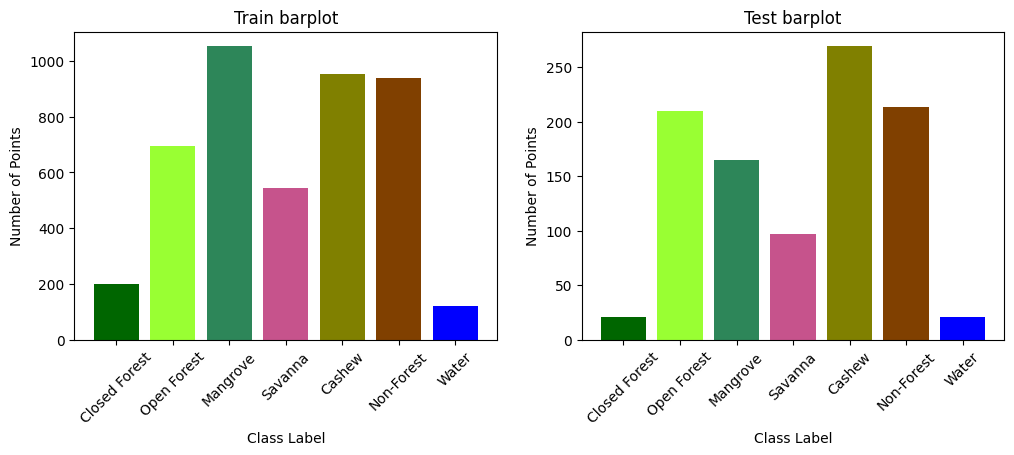

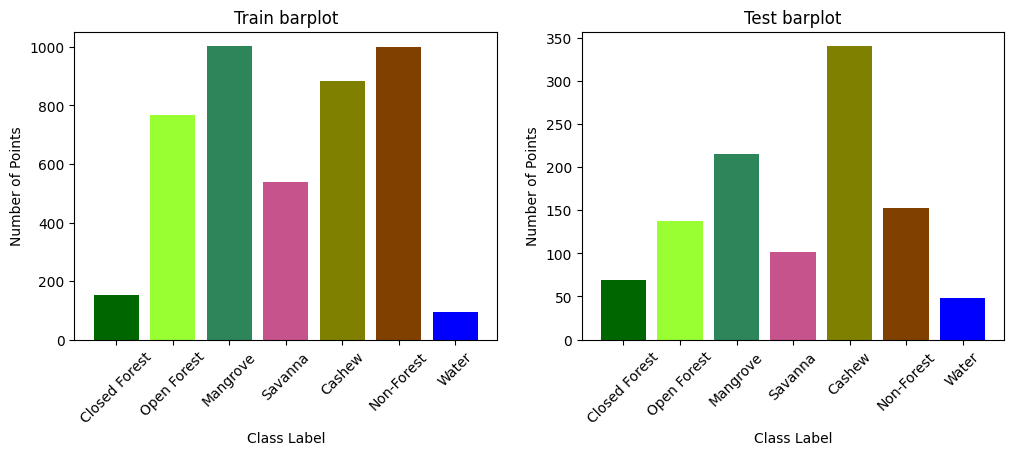

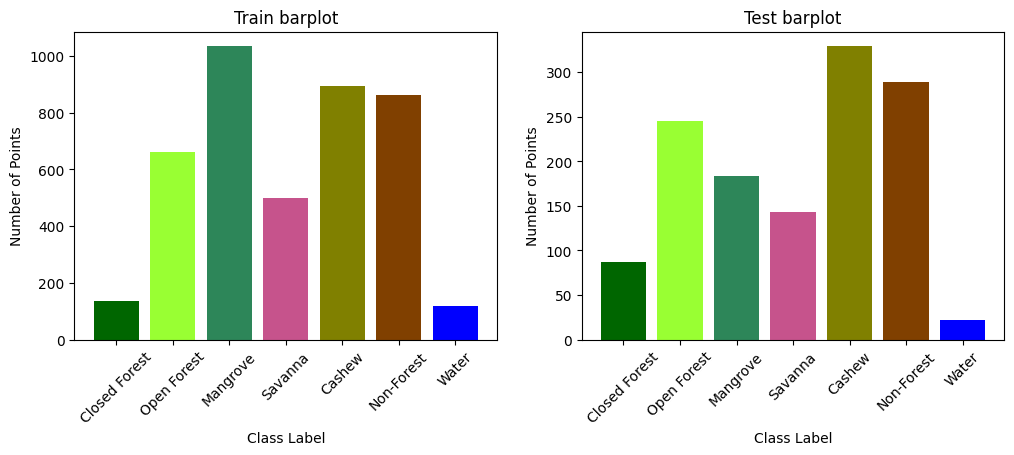

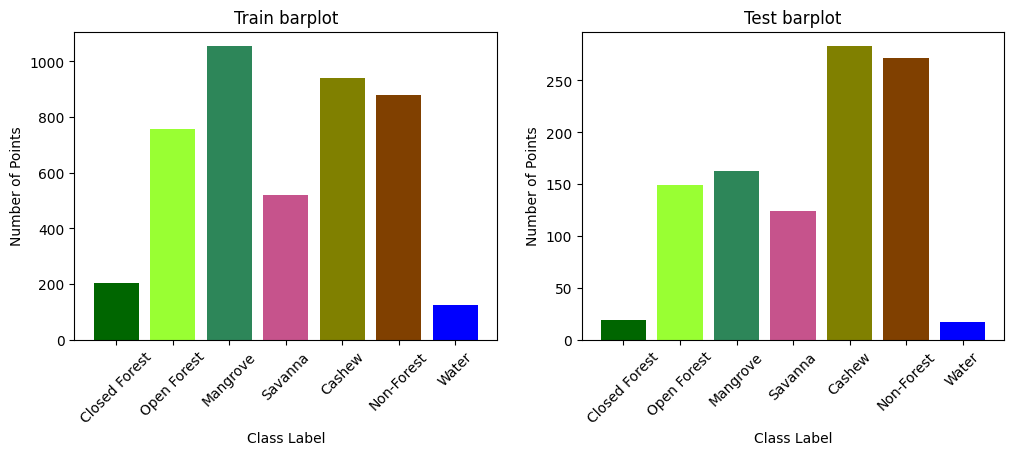

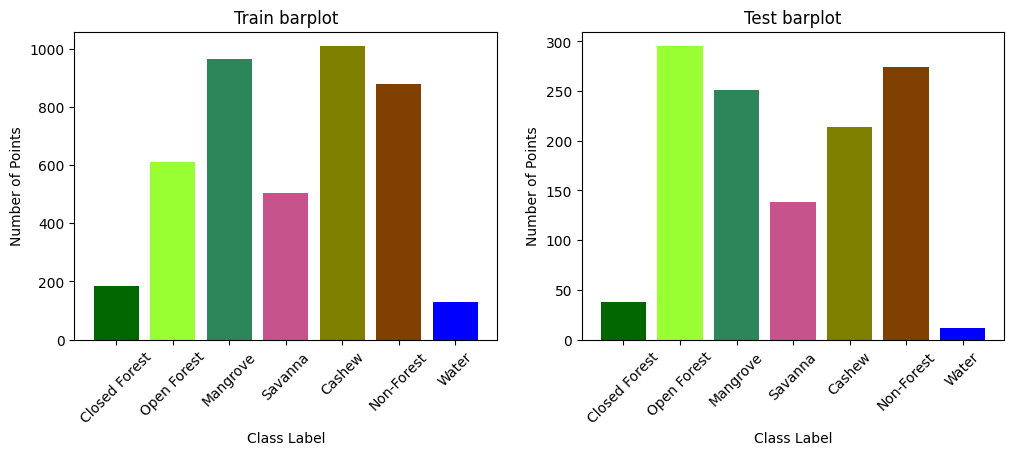

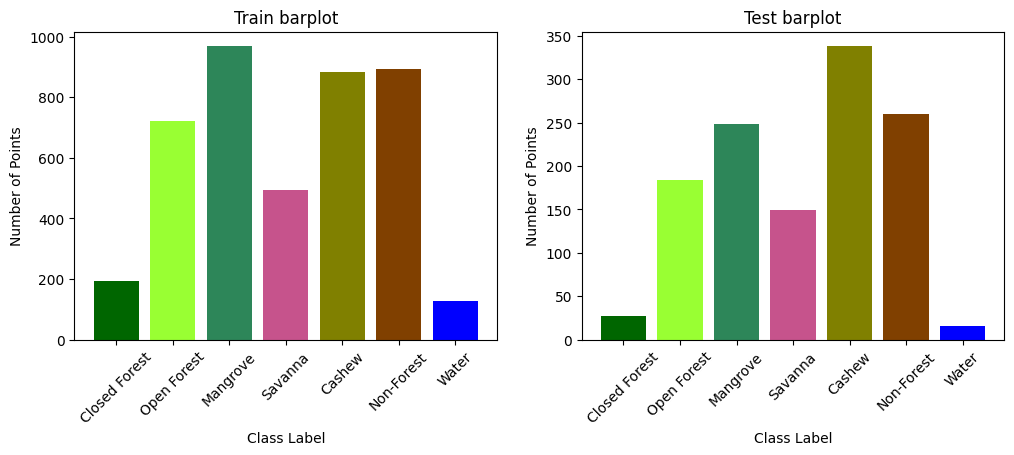

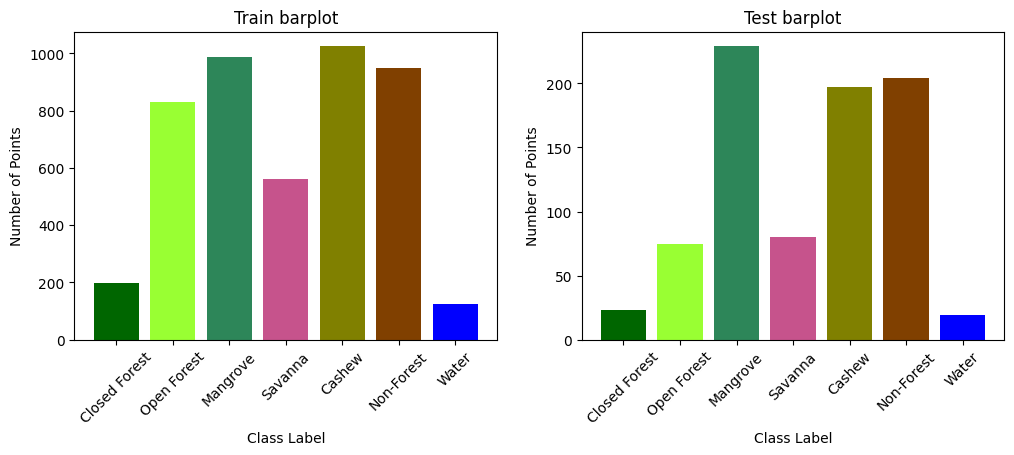

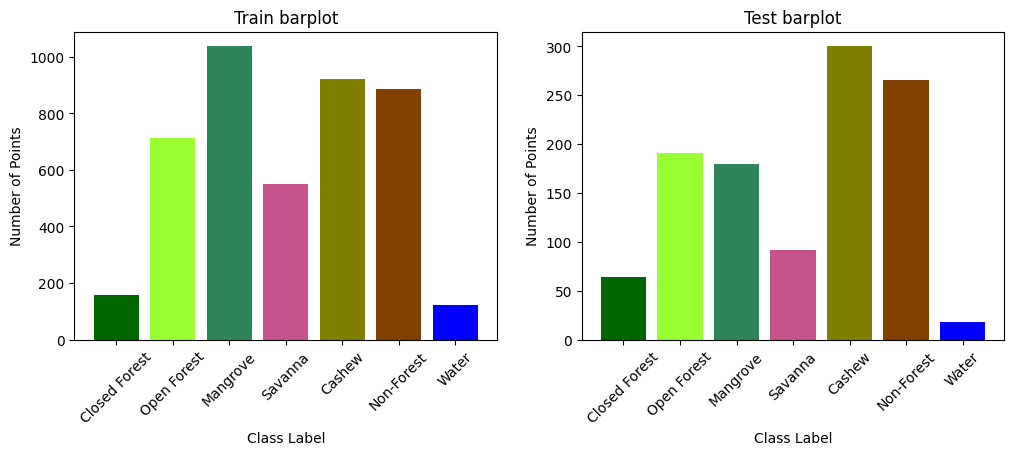

Train 

  Closed Forest    Open Forest    Mangrove    Savanna    Cashew    Non-Forest    Water
---------------  -------------  ----------  ---------  --------  ------------  -------
          0.032          0.163       0.237      0.108     0.227         0.207    0.026
          0.028          0.163       0.226      0.122     0.227         0.209    0.025
          0.045          0.154       0.233      0.121     0.211         0.208    0.027
          0.034          0.173       0.226      0.122     0.199         0.225    0.021
          0.032          0.157       0.246      0.119     0.212         0.205    0.029
          0.045          0.169       0.236      0.116     0.21          0.197    0.028
          0.043          0.143       0.226      0.118     0.236         0.205    0.03
          0.046          0.168       0.226      0.115     0.207         0.208    0.029
          0.043          0.178       0.211      0.12      0.219         0.203    0.026
          0.036          0.163      

In [57]:
def multipleHoldouts_show(X, y, groups, n_iter=10):
    best_iterations = multipleHoldouts(X,y,groups,n_iter)
    unique_labels, label_counts = np.unique(y, return_counts=True)

    percentages_train = []
    percentages_val = []
    
    for i,best_iter in enumerate(best_iterations):
        sgkf = StratifiedGroupKFold(n_splits=5,shuffle=True,random_state=i)
        # Use the selected fold as your test set
        test_fold = list(sgkf.split(X, y, groups))[best_iter]
        train_index, test_index = test_fold
        xx_train, xx_val, yy_train, yy_val = X.values[train_index], X.values[test_index], y.values[train_index], y.values[test_index]
        clusters_train = groups[train_index]
        clusters_test = groups[test_index]
        
        unique_labels_train, label_counts_train = np.unique(yy_train, return_counts=True)
        unique_labels_test, label_counts_test = np.unique(yy_val, return_counts=True)
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1,2,1)
    
        per_train = []
        per_val = []
        for j, label in enumerate(unique_labels_train):
            plt.bar(label, label_counts_train[j], color=palette[j]) #Contagens
            #plt.bar(label, label_counts_train[j]/len(yy_train), color=palette[j]) #Normalized
            per_train.append(label_counts_train[j]/len(yy_train))
        
        plt.xticks(ticks=np.arange(1,8),labels=class_names,rotation=45)
        plt.xlabel('Class Label')
        plt.ylabel('Number of Points')
        plt.title("Train barplot")
    
        plt.subplot(1,2,2)
        
        for j, label in enumerate(unique_labels_test):
            plt.bar(label, label_counts_test[j], color=palette[j]) #Contagens
            #plt.bar(label, label_counts_test[j]/len(yy_val), color=palette[j]) #Normalized
            per_val.append(label_counts_test[j]/len(yy_val))
        
        plt.xticks(ticks=np.arange(1,8),labels=class_names,rotation=45)
        plt.xlabel('Class Label')
        plt.ylabel('Number of Points')
        plt.title("Test barplot")
        plt.show()
    
        percentages_train.append(per_train)
        percentages_val.append(per_val)

    percentages_train = np.array(percentages_train)
    percentages_val = np.array(percentages_val)
    print("Train \n")
    print(tabulate(np.round(percentages_train,3), headers=class_names))
    print("\n Test \n")
    print(tabulate(np.round(percentages_val,3), headers=class_names))

multipleHoldouts_show(X,y,groups)

* __Treinar modelo para cada uma das situações de holdout__

In [67]:
def performanceSGH(model, X, y, groups, n_iter=10):
    '''
    Evaluation of perfomance, for a certain sklearn model, with the stratified grouped holdout procedure
    '''
    best_iterations = multipleHoldouts(X,y,groups,n_iter)
    unique_labels, label_counts = np.unique(y, return_counts=True)

    acc_train = []
    recall_train = []
    f1_train = []
    
    acc_test = []
    recall_test = []
    f1_test = []
    
    for i,best_iter in enumerate(best_iterations):
        sgkf = StratifiedGroupKFold(n_splits=5,shuffle=True,random_state=i)
        # Use the selected fold as your test set
        test_fold = list(sgkf.split(X, y, groups))[best_iter]
        train_index, test_index = test_fold
        xx_train, xx_val, yy_train, yy_val = X.values[train_index], X.values[test_index], y.values[train_index], y.values[test_index]
        clusters_train = groups[train_index]
        clusters_test = groups[test_index]
    
        print("Iteration " + str(i) + ":")
    
        model.fit(xx_train,yy_train)
    
        #train set results
        preds_train = model.predict(xx_train)
        
        acc_train.append(np.round(rf.score(xx_train,yy_train),3))
        recall_train.append(np.round( metrics.recall_score(yy_train, preds_train, labels=[5], average='micro'), 3))
        f1_train.append(np.round(f1_score(yy_train,preds_train,average=None),3)[4]) #[4] to only get cashew result
        
        print("Accuracy train: ", np.round(model.score(xx_train,yy_train),3))
        print("Recall cashew train: ", np.round( metrics.recall_score(yy_train, preds_train, labels=[5], average='micro'), 3))
        print("F1-score train: ", np.round(f1_score(yy_train,preds_train,average=None),3))
        print("\n")
        
        # test set results
        preds = model.predict(xx_val)
    
        acc_test.append(np.round(rf.score(xx_val,yy_val),3))
        recall_test.append(np.round( metrics.recall_score(yy_val, preds, labels=[5], average='micro'), 3))
        f1_test.append(np.round(f1_score(yy_val,preds,average=None),3)[4])
        
        print("Accuracy test: ", np.round(model.score(xx_val,yy_val),3)) #accuracy
        print("Recall cashew test: ", np.round( metrics.recall_score(yy_val, preds, labels=[5], average='micro'), 3) )
        print("F1-score test: ", np.round(f1_score(yy_val,preds,average=None),3))
        
        cm = metrics.confusion_matrix(yy_val,preds,labels=np.arange(1,8))
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels=np.array(class_names))
        cm_display.plot()
        plt.xticks(rotation = 45)
        plt.show()

    # Show tabulates
    headers=["Ov. Accuracy", "Recall Cashew", "F1-score Cashew"]
    print("Train \n")
    print(tabulate(np.round( np.array([acc_train,recall_train,f1_train]).transpose() ,3), headers=headers))
    print("\n Test \n")
    print(tabulate(np.round( np.array([acc_test,recall_test,f1_test]).transpose() ,3), headers=headers))
    
    return acc_train, recall_train, f1_train, acc_test, recall_test, f1_test

<a id="melhoraccuracy"></a>
____

## RF que maximiza overall accuracy

{'max_depth': 11.0, 'max_features': 9.0, 'n_estimators': 486.0}

<a href="#topotopo"> Back to top.</a>

Iteration 0:
Accuracy train:  0.989
Recall cashew train:  0.993
F1-score train:  [0.932 0.973 0.999 0.99  0.991 0.995 0.996]


Accuracy test:  0.824
Recall cashew test:  0.871
F1-score test:  [0.34  0.677 0.972 0.904 0.759 0.953 0.902]


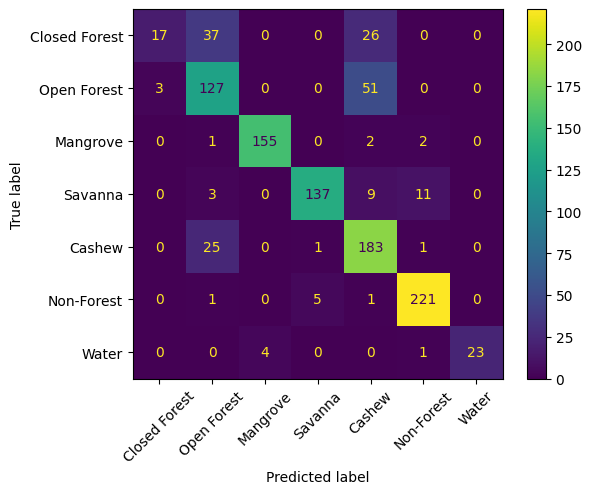

Iteration 1:
Accuracy train:  0.989
Recall cashew train:  0.995
F1-score train:  [0.938 0.972 0.998 0.992 0.988 0.995 0.995]


Accuracy test:  0.835
Recall cashew test:  0.903
F1-score test:  [0.224 0.736 0.963 0.747 0.878 0.926 1.   ]


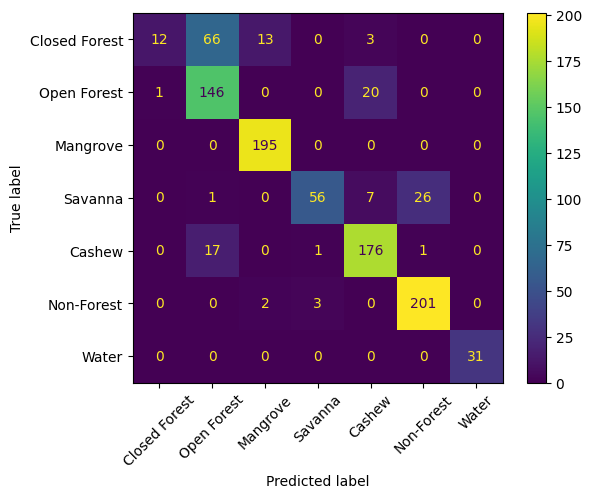

Iteration 2:
Accuracy train:  0.99
Recall cashew train:  0.994
F1-score train:  [0.959 0.972 0.998 0.995 0.988 0.997 0.996]


Accuracy test:  0.802
Recall cashew test:  0.84
F1-score test:  [0.286 0.629 0.976 0.711 0.79  0.893 1.   ]


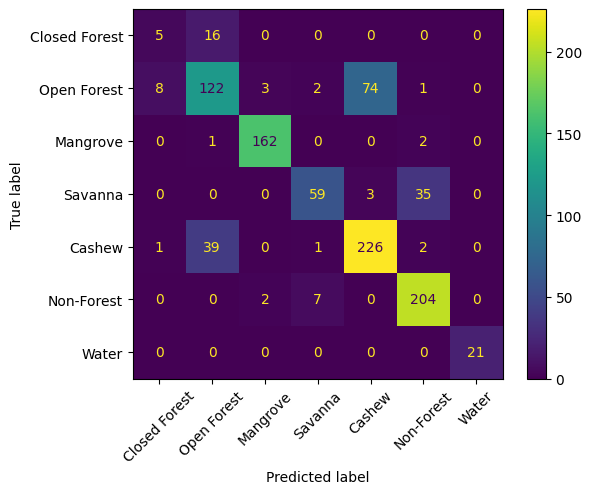

Iteration 3:
Accuracy train:  0.986
Recall cashew train:  0.984
F1-score train:  [0.919 0.965 0.999 0.995 0.982 0.997 0.995]


Accuracy test:  0.829
Recall cashew test:  0.912
F1-score test:  [0.391 0.521 0.984 0.844 0.865 0.885 0.968]


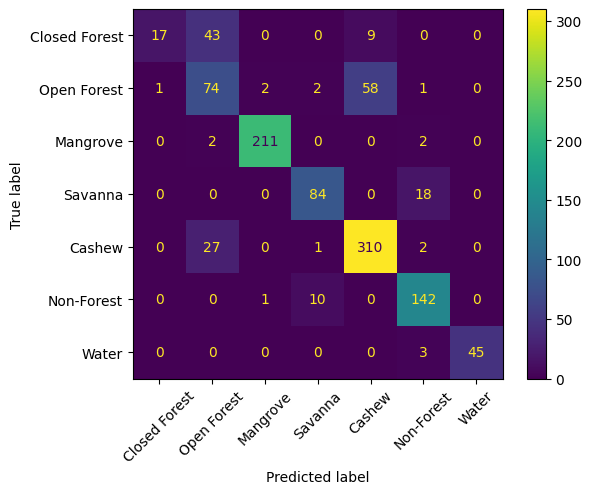

Iteration 4:
Accuracy train:  0.992
Recall cashew train:  0.996
F1-score train:  [0.962 0.98  0.998 0.994 0.992 0.996 0.996]


Accuracy test:  0.838
Recall cashew test:  0.851
F1-score test:  [0.376 0.642 0.981 0.933 0.821 0.973 1.   ]


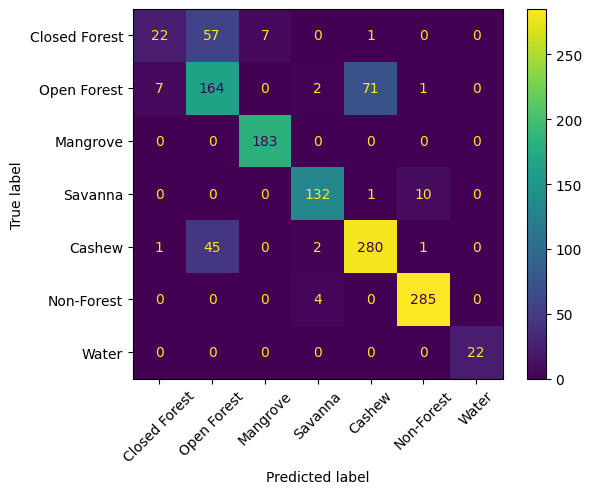

Iteration 5:
Accuracy train:  0.987
Recall cashew train:  0.994
F1-score train:  [0.951 0.964 0.999 0.995 0.982 0.998 0.996]


Accuracy test:  0.834
Recall cashew test:  0.866
F1-score test:  [0.593 0.561 0.982 0.786 0.822 0.922 0.909]


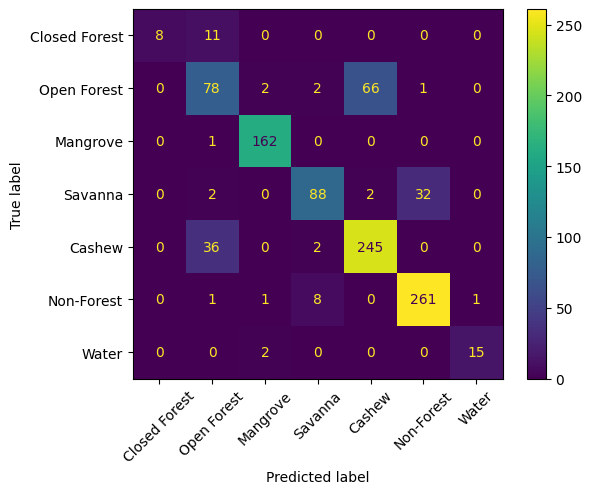

Iteration 6:
Accuracy train:  0.992
Recall cashew train:  0.997
F1-score train:  [0.969 0.978 0.999 0.995 0.993 0.997 0.996]


Accuracy test:  0.795
Recall cashew test:  0.687
F1-score test:  [0.586 0.572 0.984 0.94  0.589 0.964 0.909]


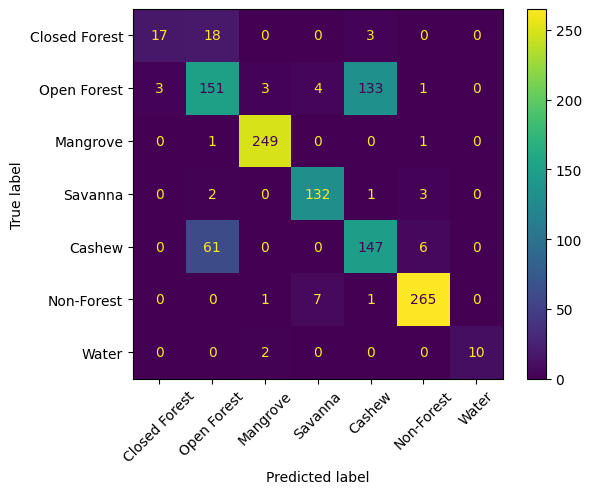

Iteration 7:
Accuracy train:  0.987
Recall cashew train:  0.99
F1-score train:  [0.949 0.97  0.998 0.992 0.986 0.995 0.996]


Accuracy test:  0.87
Recall cashew test:  0.855
F1-score test:  [0.667 0.656 0.971 0.91  0.84  0.952 1.   ]


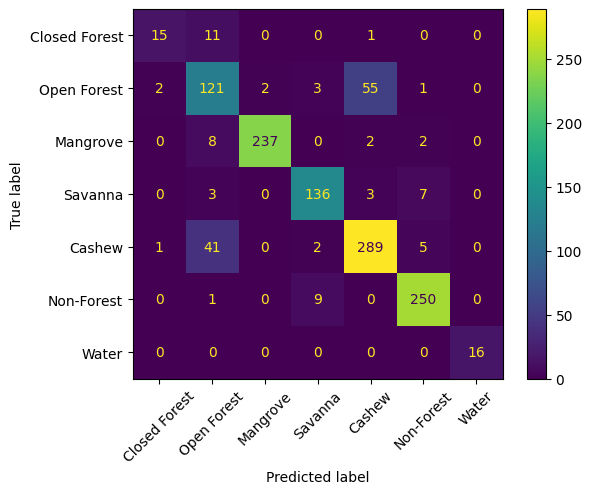

Iteration 8:
Accuracy train:  0.987
Recall cashew train:  0.987
F1-score train:  [0.964 0.971 0.997 0.992 0.984 0.995 0.996]


Accuracy test:  0.879
Recall cashew test:  0.812
F1-score test:  [0.296 0.627 0.98  0.868 0.865 0.941 0.974]


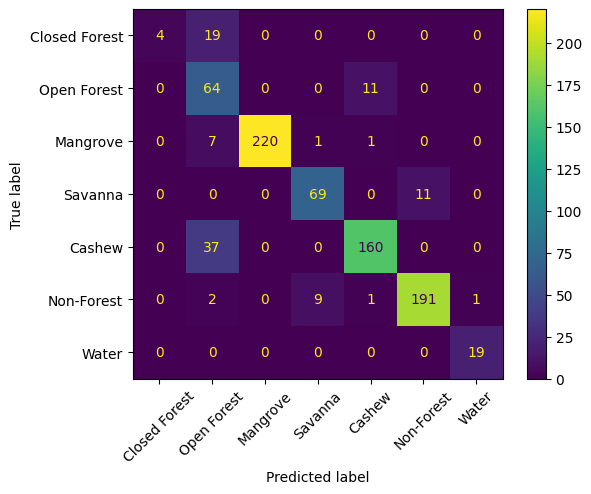

Iteration 9:
Accuracy train:  0.988
Recall cashew train:  0.993
F1-score train:  [0.94  0.971 0.999 0.993 0.988 0.996 0.996]


Accuracy test:  0.875
Recall cashew test:  0.83
F1-score test:  [0.612 0.735 0.994 0.895 0.847 0.97  1.   ]


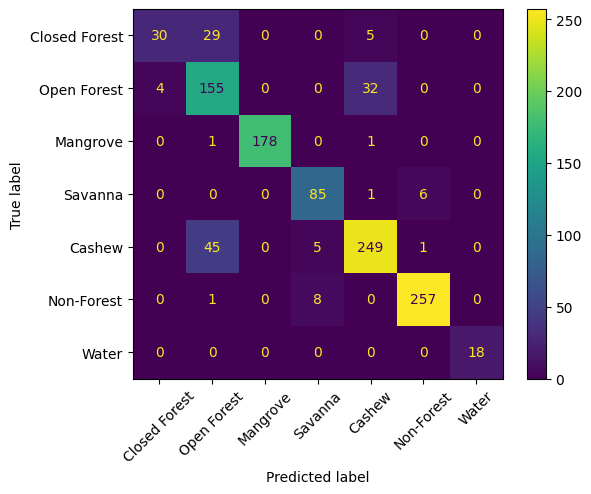

Train 

  Ov. Accuracy    Recall Cashew    F1-score Cashew
--------------  ---------------  -----------------
         0.989            0.993              0.991
         0.989            0.995              0.988
         0.99             0.994              0.988
         0.986            0.984              0.982
         0.992            0.996              0.992
         0.987            0.994              0.982
         0.992            0.997              0.993
         0.987            0.99               0.986
         0.987            0.987              0.984
         0.988            0.993              0.988

 Test 

  Ov. Accuracy    Recall Cashew    F1-score Cashew
--------------  ---------------  -----------------
         0.824            0.871              0.759
         0.835            0.903              0.878
         0.802            0.84               0.79
         0.829            0.912              0.865
         0.838            0.851              0.821
         0.834 

([0.989, 0.989, 0.99, 0.986, 0.992, 0.987, 0.992, 0.987, 0.987, 0.988],
 [0.993, 0.995, 0.994, 0.984, 0.996, 0.994, 0.997, 0.99, 0.987, 0.993],
 [0.991, 0.988, 0.988, 0.982, 0.992, 0.982, 0.993, 0.986, 0.984, 0.988],
 [0.824, 0.835, 0.802, 0.829, 0.838, 0.834, 0.795, 0.87, 0.879, 0.875],
 [0.871, 0.903, 0.84, 0.912, 0.851, 0.866, 0.687, 0.855, 0.812, 0.83],
 [0.759, 0.878, 0.79, 0.865, 0.821, 0.822, 0.589, 0.84, 0.865, 0.847])

In [69]:
rf = RandomForestClassifier(n_estimators=486, max_features=9,max_depth=11,random_state=42)

performanceSGH(rf,X,y,groups,n_iter=10)

Iteration 0:
Accuracy train:  0.987
Recall cashew train:  0.998
F1-score train:  [0.953 0.967 0.998 0.989 0.987 0.995 0.995]


Accuracy test:  0.862
Recall cashew test:  0.91
F1-score test:  [0.554 0.765 0.977 0.885 0.812 0.881 0.972]


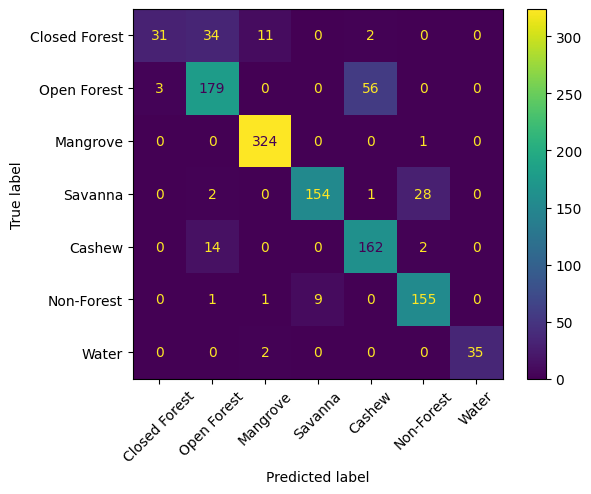

Iteration 1:
Accuracy train:  0.987
Recall cashew train:  0.993
F1-score train:  [0.944 0.969 0.999 0.989 0.986 0.994 0.996]


Accuracy test:  0.843
Recall cashew test:  0.748
F1-score test:  [0.383 0.664 0.99  0.914 0.799 0.928 0.929]


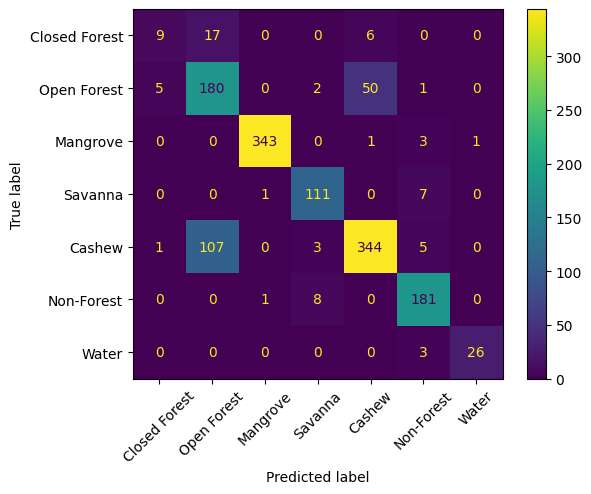

Iteration 2:
Accuracy train:  0.987
Recall cashew train:  0.987
F1-score train:  [0.956 0.969 0.999 0.995 0.982 0.997 1.   ]


Accuracy test:  0.877
Recall cashew test:  0.913
F1-score test:  [0.    0.721 0.959 0.692 0.931 0.897 0.921]


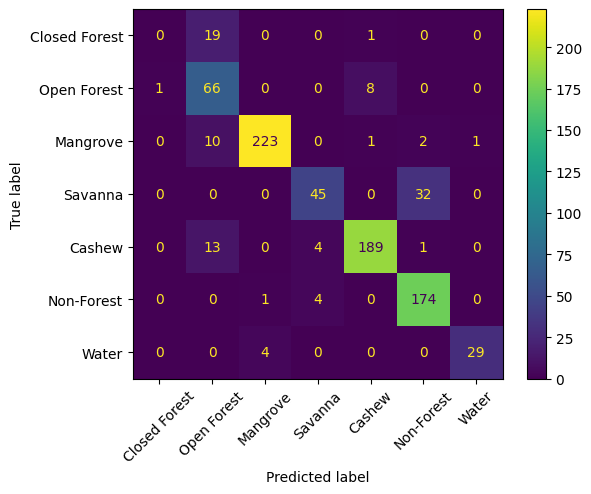

Iteration 3:
Accuracy train:  0.988
Recall cashew train:  0.991
F1-score train:  [0.96  0.966 0.998 0.998 0.984 0.998 0.996]


Accuracy test:  0.895
Recall cashew test:  0.934
F1-score test:  [0.316 0.72  0.99  0.896 0.815 0.976 1.   ]


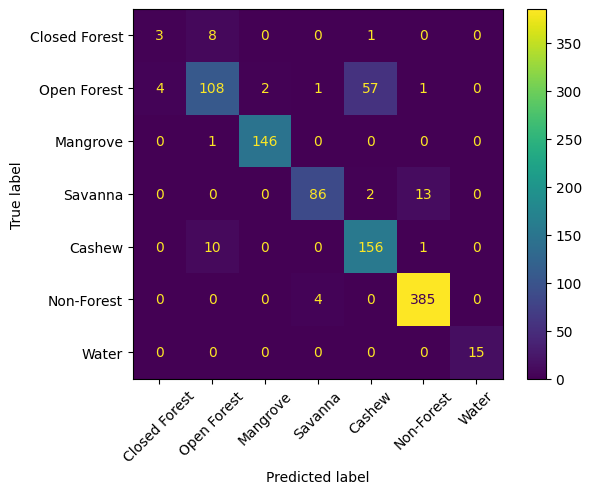

Iteration 4:
Accuracy train:  0.989
Recall cashew train:  0.993
F1-score train:  [0.932 0.973 0.999 0.99  0.991 0.995 0.996]


Accuracy test:  0.824
Recall cashew test:  0.871
F1-score test:  [0.34  0.677 0.972 0.904 0.759 0.953 0.902]


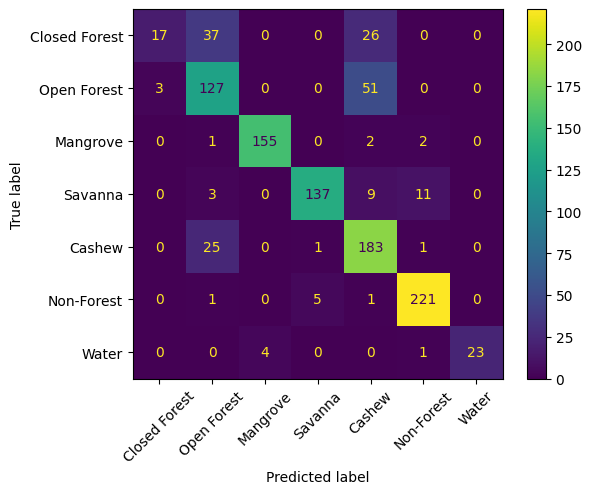

In [50]:
palette = ['#006600', '#99ff33', '#2d8659', '#c6538c', '#808000', '#804000', '#0000ff']

n_iter = 10

#for r in range(n_iter):
#    sgkf = StratifiedGroupKFold(n_splits=5,shuffle=True,random_state=r)

acc_train = []
recall_train = []
f1_train = []

acc_test = []
recall_test = []
f1_test = []

for i, (train_index, test_index) in enumerate(sgkf.split(X, y, groups)):
    xx_train = X.iloc[train_index,:]
    xx_val = X.iloc[test_index,:]
    
    yy_train = y[train_index]
    yy_val = y[test_index]

    print("Iteration " + str(i) + ":")

    #rf = RandomForestClassifier(n_estimators=50, max_features="sqrt",max_depth=5,random_state=random_state)
    rf = RandomForestClassifier(n_estimators=486, max_features=9,max_depth=11,random_state=42)
    rf.fit(xx_train,yy_train) # dá fit, mas não dá plot

    #train set results
    preds_train = rf.predict(xx_train)
    
    acc_train.append(np.round(rf.score(xx_train,yy_train),3))
    recall_train.append(np.round( metrics.recall_score(yy_train, preds_train, labels=[5], average='micro'), 3))
    f1_train.append(np.round(f1_score(yy_train,preds_train,average=None),3)[4]) #[4] to only get cashew result
    
    print("Accuracy train: ", np.round(rf.score(xx_train,yy_train),3)) #accuracy
    print("Recall cashew train: ", np.round( metrics.recall_score(yy_train, preds_train, labels=[5], average='micro'), 3))
    print("F1-score train: ", np.round(f1_score(yy_train,preds_train,average=None),3))
    print("\n")
    
    # test set results
    preds = rf.predict(xx_val)

    acc_test.append(np.round(rf.score(xx_val,yy_val),3))
    recall_test.append(np.round( metrics.recall_score(yy_val, preds, labels=[5], average='micro'), 3))
    f1_test.append(np.round(f1_score(yy_val,preds,average=None),3)[4])
    
    print("Accuracy test: ", np.round(rf.score(xx_val,yy_val),3)) #accuracy
    print("Recall cashew test: ", np.round( metrics.recall_score(yy_val, preds, labels=[5], average='micro'), 3) )
    print("F1-score test: ", np.round(f1_score(yy_val,preds,average=None),3))
    
    cm = metrics.confusion_matrix(yy_val,preds,labels=np.arange(1,8))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels=np.array(class_names))
    cm_display.plot()
    plt.xticks(rotation = 45)
    plt.show()

* __4. Avaliação no test set!__

Accuracy train:  0.988
Recall cashew train:  0.994
F1-score train:  [0.975 0.97  0.997 0.991 0.986 0.994 0.996]


Accuracy test:  0.909
Recall cashew test:  0.895
F1-score test:  [0.25  0.84  0.996 0.914 0.868 0.956 0.966]


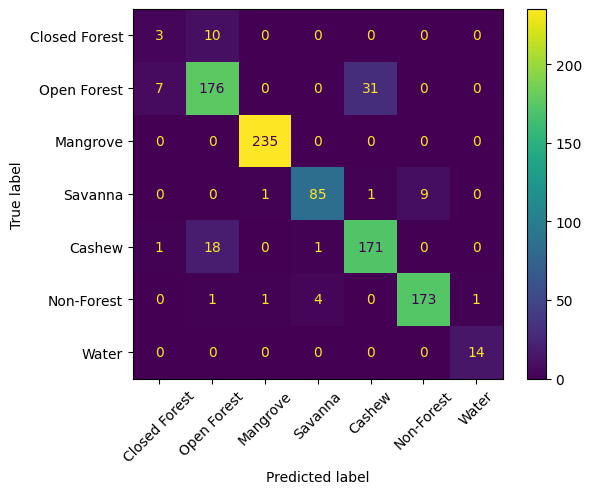

In [54]:
rf = RandomForestClassifier(n_estimators=486, max_features=9,max_depth=11,random_state=42)
rf.fit(X_train,y_train) # dá fit, mas não dá plot

preds_train = rf.predict(X_train)
print("Accuracy train: ", np.round(rf.score(X_train,y_train),3)) #accuracy
print("Recall cashew train: ", np.round( metrics.recall_score(y_train, preds_train, labels=[5], average='micro'), 3) )
print("F1-score train: ", np.round(f1_score(y_train,preds_train,average=None),3))
print("\n")

# test set results
preds = rf.predict(X_test)
print("Accuracy test: ", np.round(rf.score(X_test,y_test),3)) #accuracy
print("Recall cashew test: ", np.round( metrics.recall_score(y_test, preds, labels=[5], average='micro'), 3) )
print("F1-score test: ", np.round(f1_score(y_test,preds,average=None),3))

cm = metrics.confusion_matrix(y_test,preds,labels=np.arange(1,8))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels=np.array(class_names))
cm_display.plot()
plt.xticks(rotation = 45)
plt.show()

<a id="melhorf1"></a>
____

## RF que maximiza F1-score Cashew

{'max_depth': 8.0, 'max_features': 19.0, 'n_estimators': 98.0}

<a href="#topotopo"> Back to top.</a>

In [44]:
np.round(f1_score(y_test,preds,average=None),3)

array([0.25 , 0.84 , 0.996, 0.914, 0.868, 0.956, 0.966])

In [47]:
accuracy_score(y_test,preds)

0.9088016967126193

Iteration 0:
Accuracy train:  0.969
Recall cashew train:  0.965
F1-score train:  [0.928 0.927 0.995 0.971 0.962 0.983 0.975]


Accuracy test:  0.81
Recall cashew test:  0.768
F1-score test:  [0.    0.533 0.98  0.892 0.763 0.975 1.   ]


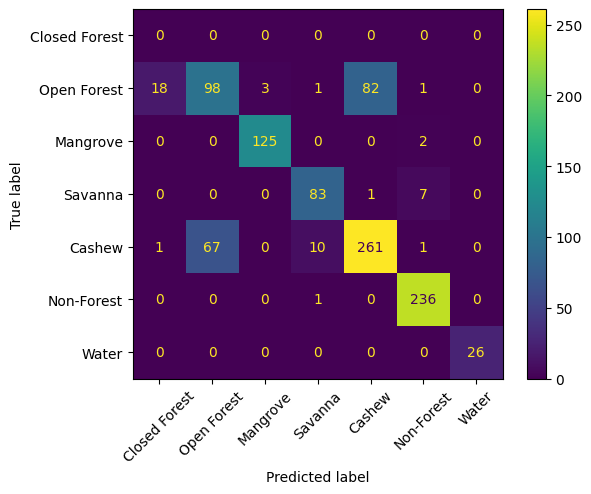

Iteration 1:
Accuracy train:  0.967
Recall cashew train:  0.973
F1-score train:  [0.921 0.925 0.995 0.956 0.963 0.982 0.986]


Accuracy test:  0.875
Recall cashew test:  0.865
F1-score test:  [0.486 0.742 0.965 0.94  0.858 0.931 0.971]


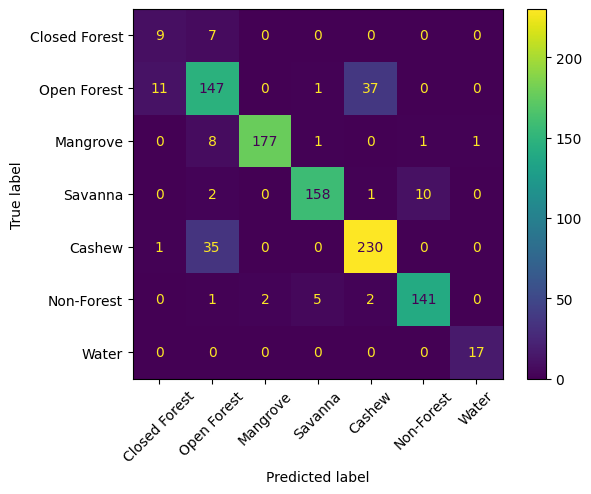

Iteration 2:
Accuracy train:  0.967
Recall cashew train:  0.976
F1-score train:  [0.893 0.922 0.999 0.963 0.963 0.981 0.99 ]


Accuracy test:  0.793
Recall cashew test:  0.797
F1-score test:  [0.301 0.619 0.983 0.884 0.632 0.903 0.957]


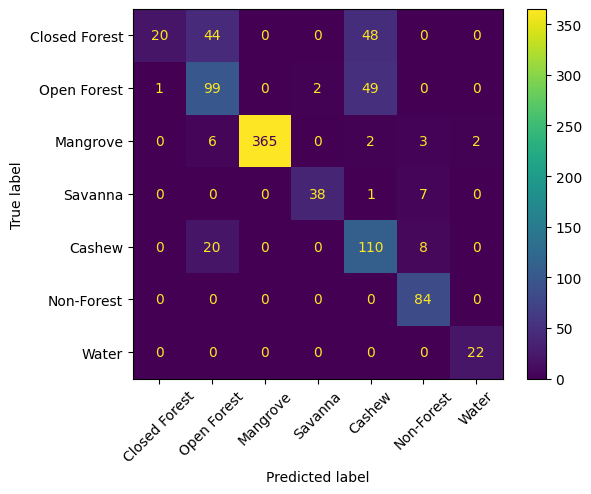

Iteration 3:
Accuracy train:  0.961
Recall cashew train:  0.977
F1-score train:  [0.89  0.912 0.993 0.982 0.95  0.988 0.974]


Accuracy test:  0.879
Recall cashew test:  0.966
F1-score test:  [0.533 0.784 0.99  0.691 0.91  0.902 0.906]


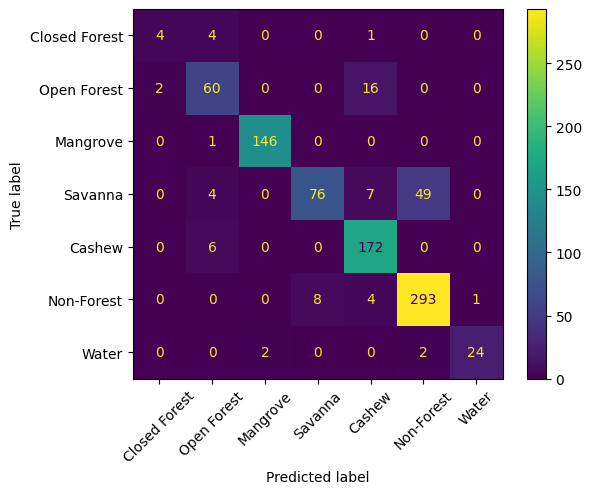

Iteration 4:
Accuracy train:  0.957
Recall cashew train:  0.973
F1-score train:  [0.782 0.902 0.995 0.968 0.947 0.985 0.995]


Accuracy test:  0.847
Recall cashew test:  0.89
F1-score test:  [0.452 0.553 0.947 0.9   0.855 0.949 0.852]


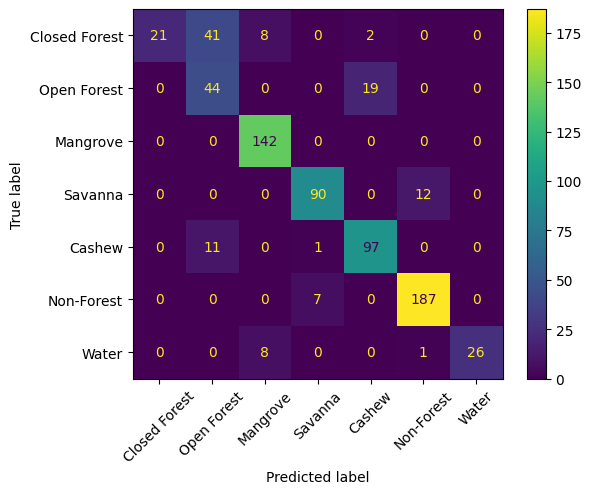

In [51]:
palette = ['#006600', '#99ff33', '#2d8659', '#c6538c', '#808000', '#804000', '#0000ff']

sgkf = StratifiedGroupKFold(n_splits=5,shuffle=True,random_state=0)

for i, (train_index, test_index) in enumerate(sgkf.split(X_train, y_train, groups_train)):
    xx_train = X_train.iloc[train_index,:]
    xx_val = X_train.iloc[test_index,:]
    
    yy_train = y_train[train_index]
    yy_val = y_train[test_index]

    print("Iteration " + str(i) + ":")

    rf = RandomForestClassifier(n_estimators=98, max_depth=8, max_features=19, random_state=42)
    rf.fit(xx_train,yy_train) # dá fit, mas não dá plot
    
    preds_train = rf.predict(xx_train)
    print("Accuracy train: ", np.round(rf.score(xx_train,yy_train),3)) #accuracy
    print("Recall cashew train: ", np.round( metrics.recall_score(yy_train, preds_train, labels=[5], average='micro'), 3))
    print("F1-score train: ", np.round(f1_score(yy_train,preds_train,average=None),3))
    print("\n")
    # test set results
    preds = rf.predict(xx_val)
    print("Accuracy test: ", np.round(rf.score(xx_val,yy_val),3)) #accuracy
    print("Recall cashew test: ", np.round( metrics.recall_score(yy_val, preds, labels=[5], average='micro'), 3) )
    print("F1-score test: ", np.round(f1_score(yy_val,preds,average=None),3))
    
    cm = metrics.confusion_matrix(yy_val,preds,labels=np.arange(1,8))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels=np.array(class_names))
    cm_display.plot()
    plt.xticks(rotation = 45)
    plt.show()

Accuracy train:  0.956
Recall cashew train:  0.968
F1-score train:  [0.883 0.901 0.993 0.953 0.947 0.977 0.984]


Accuracy test:  0.916
Recall cashew test:  0.916
F1-score test:  [0.211 0.855 0.996 0.918 0.884 0.953 0.933]


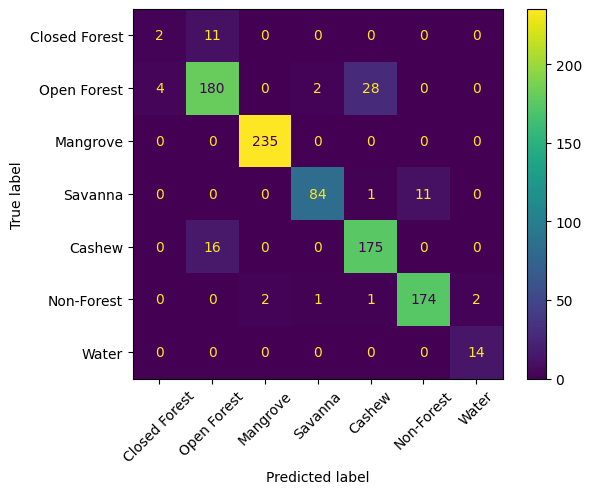

In [53]:
rf = RandomForestClassifier(n_estimators=98, max_depth=8, max_features=19, random_state=42)
rf.fit(X_train,y_train) # dá fit, mas não dá plot

preds_train = rf.predict(X_train)
print("Accuracy train: ", np.round(rf.score(X_train,y_train),3)) #accuracy
print("Recall cashew train: ", np.round( metrics.recall_score(y_train, preds_train, labels=[5], average='micro'), 3) )
print("F1-score train: ", np.round(f1_score(y_train,preds_train,average=None),3))
print("\n")

# test set results
preds = rf.predict(X_test)
print("Accuracy test: ", np.round(rf.score(X_test,y_test),3)) #accuracy
print("Recall cashew test: ", np.round( metrics.recall_score(y_test, preds, labels=[5], average='micro'), 3) )
print("F1-score test: ", np.round(f1_score(y_test,preds,average=None),3))

cm = metrics.confusion_matrix(y_test,preds,labels=np.arange(1,8))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels=np.array(class_names))
cm_display.plot()
plt.xticks(rotation = 45)
plt.show()

* __Resultados em CV:__ modelo sem pruning com 300 base learners comporta-se melhor. Está claramente overfitted, tem accuracy de 1.0 em treino. Validation, não atinge valores tão baixos como 250_44, mas também não chega a valores tão elevados. Por ser mais consistente no entanto, média de accuracy nas várias runs é superior.
* __Resultados em unseen data (test set):__ são muito muito equiparados, o que indica que o overfitted não ganha nesse aspeto.

<a id="geemap"></a>
_____

# __Importar modelo para GEE__

<a href="#topotopo"> Back to top.</a>

In [11]:
X_train = treino.drop(columns=["C_ID_1","longitude","latitude","groupID"])
y_train = treino["C_ID_1"]
coords_train = treino[["longitude","latitude"]]
groups_train = treino["groupID"]

X_test = teste.drop(columns=["C_ID_1","longitude","latitude","groupID"])
y_test = teste["C_ID_1"]
coords_test = teste[["longitude","latitude"]]
groups_test = teste["groupID"]

In [13]:
X = pd.concat([X_train,X_test],ignore_index=True)
y = pd.concat([y_train,y_test],ignore_index=True)

In [14]:
rf = RandomForestClassifier(n_estimators=250, max_features=44,max_depth=9,random_state=42)
rf.fit(X,y) 

preds = rf.predict(X)
print("Accuracy train: ", np.round(rf.score(X,y),3))
print("Recall cashew train: ", np.round( metrics.recall_score(y, preds, labels=[5], average='micro'), 3) )

Accuracy train:  0.972
Recall cashew train:  0.98


In [15]:
import ee
import geemap
import pandas as pd

from geemap import ml
from sklearn import ensemble

In [16]:
geemap.ee_initialize()

In [17]:
user_id = geemap.ee_user_id()
user_id

# specify asset id where to save trees
# be sure to change  to your ee user name
asset_id = user_id + "/RF_250_44_9_42"
asset_id

'users/up201906711/RF_250_44_9_42'

In [21]:
feature_names = list(X.columns)

trees = ml.rf_to_strings(rf, feature_names)

In [24]:
# kick off an export process so it will be saved to the ee asset
ml.export_trees_to_fc(trees, asset_id)

# this will kick off an export task, so wait a few minutes before moving on